<img src='pics/otus.png'>

In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

# Уменьшение размерности 

## Проклятие размерности

Часто датасеты состоят из очень большого количества признаков - тысячи.  
Это затрудняет поиск моделей.  
Можно сильно уменьшить размерность без больших потерь информации, то есть сократить объем входных данных, упростить рассчет модели.

<img src="pics/dims.png">

Пространство вариантов растет экспоненциально:

Рассмотрим отрезок длины 10  

$$10^1 = 10$$
$$10^2 = 100$$
$$10^3 = 1000$$
...

Экспоненциальный рост


Рассмотрим единичный гиперкуб в двумерном пространстве (квадрат $1\times1$)
Вероятность того, что точка попадет в отступ 0.001 от границы

In [2]:
1 * 1 - (1 - 0.001 * 2) * (1 - 0.001 * 2)

0.0039959999999999996

In [3]:
def point_prob(n_dimensions, length, margin):
    return length ** n_dimensions - (length - margin * 2) ** (n_dimensions)

In [4]:
point_prob(2, 1, 0.001)

0.0039959999999999996

In [5]:
point_prob(3, 1, 0.001)

0.005988007999999989

In [6]:
point_prob(10, 1, 0.001)

0.019820956648050614

In [7]:
point_prob(10000, 1, 0.001)

0.999999997979714

Среднее расстояние между точками гиперкуба:

In [8]:
from scipy.spatial import distance


def avg_dist(n_dimensions):
    dist = 0.
    n_points = 100000
    for i in range(n_points):
        p1 = np.random.rand(n_dimensions)
        p2 = np.random.rand(n_dimensions)
        dist += distance.euclidean(p1, p2)
    return dist / n_points

In [9]:
# this is tooo sloooow
# avg_dist(1)
# 0.3332980439577846

In [10]:
# avg_dist(2)
# 0.5218287867554282

In [11]:
# avg_dist(3)
# 0.6621043139420382

In [12]:
# avg_dist(10)
# 1.2674922241953468

In [13]:
# avg_dist(100)
# 4.076181952866157

In [14]:
# avg_dist(1000)
# 12.906989192432318

In [15]:
# avg_dist(10000)
# 40.82415131097075

Новая точка будет далеко от других, что означает, что построенная модель скорее всего не учитывает новые данные, то есть модель недообучена или переобучена

# Уменьшение размерности с помощью проекций

<img src="pics/PearsonFig.jpg">

<img src="pics/proj.png">

<img src="pics/proj_1.png">

# PCA - Principal Component Analysis (метод главных компонент)

найти подпространства меньшей размерности, в ортогональной проекции на которые разброс данных (то есть среднеквадратичное отклонение от среднего значения) максимален

* Позволяет уменьшить число переменных, выбрав самые изменчивые из них
* Новые переменные являются линейной комбинацией старых переменных

<img src="pics/pca.png">

Будем вибирать такую ось, в которой сохраняется максимальное количество дисперсии. Так мы вероятно потеряем как можно меньше информации при проецировании.   
Следующая ось ортогональна первой, выбирается из всех других осей как ось с наибольшей оставшейся дисперсией.

Вектор, описывающий такую ось называется главной компонентой (principal component)

## Singular Value Decomposition

Для любой матрицы $X$ размера $n \times m$ и ранга $r$ можно найти разложение вида:
$$ X = U S V^\top ,$$
где 
* $U$ - унитарная матрица, состоящая из собственных векторов $XX^\top$
* $V$ - унитарная матрица, состоящая из собственных векторов $X^\top X$
* $S$ - диагональная матрица с сингулярными числами $s_i = \sqrt{\lambda_i}$

см  [PCA SVD туториал](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf)

$$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$$

In [16]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [17]:
X.shape

(60, 3)

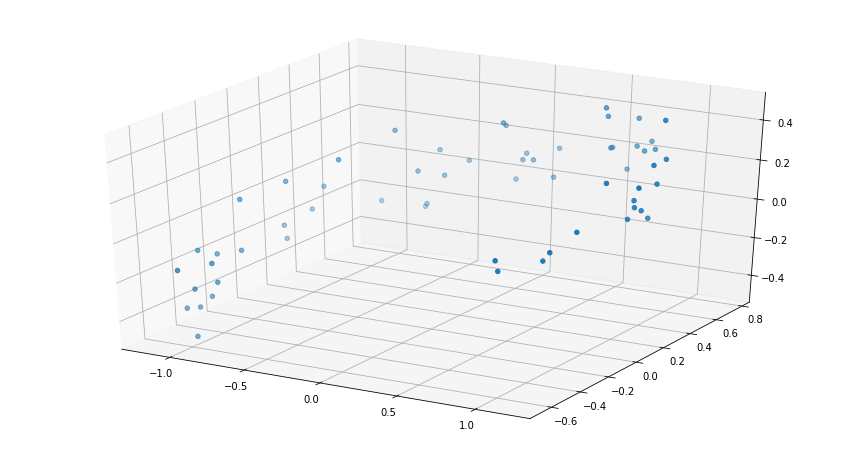

In [18]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2] )

In [19]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [20]:
Vt

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ],
       [-0.08626012, -0.31420255,  0.94542898]])


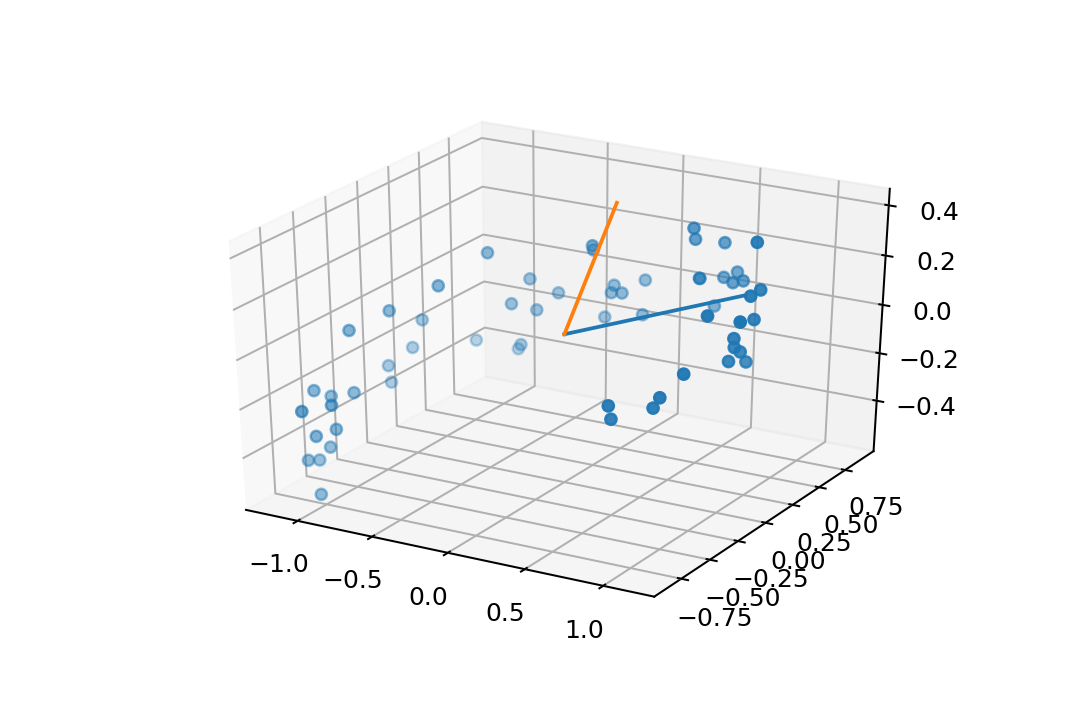

In [74]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_centered[:, 0], X_centered[:, 1], X_centered[:, 2] )
ax.plot(*zip(c1, np.zeros(c1.shape)))
ax.plot(*zip(c2, np.zeros(c2.shape)))

Проецирование:

$$X_p = X \cdot W_d$$

где $W_d$ - матрица, состоящая из первых $d$ главных компонент

In [22]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D.shape, W2.shape

((60, 2), (3, 2))

In [23]:
W2

array([[ 0.93636116, -0.34027485],
       [ 0.29854881,  0.90119108],
       [ 0.18465208,  0.2684542 ]])

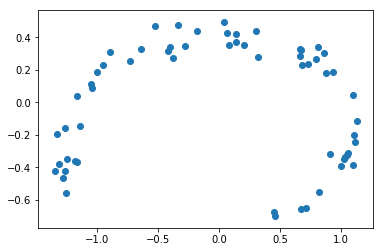

In [24]:
%matplotlib inline
plt.scatter(X2D[:, 0], X2D[:, 1])

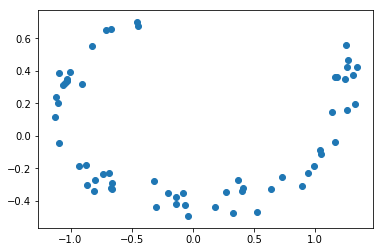

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
plt.scatter(X2D[:, 0], X2D[:, 1])

In [26]:
X3D_inv = pca.inverse_transform(X2D)
X3D_inv.shape

(60, 3)


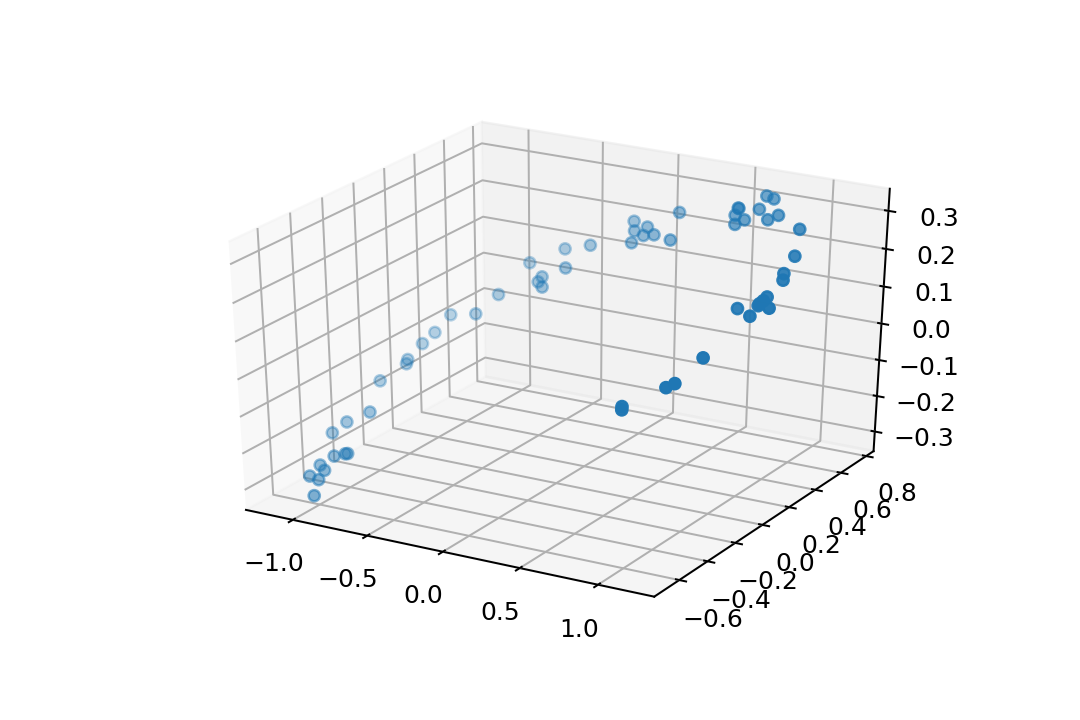

In [73]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2] )

In [28]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [29]:
pca.explained_variance_ratio_

array([ 0.84248607,  0.14631839])

## Explained Variance (Объясненная дисперсия)

In [30]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]

In [31]:
X.shape, y.shape

((70000, 784), (70000,))

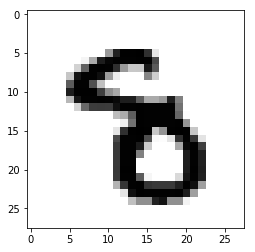

In [32]:
%matplotlib inline
plt.imshow(X[50000].reshape(28, 28), cmap=plt.cm.gray_r)

In [33]:
pca.explained_variance_ratio_.shape

(2,)

In [34]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [35]:
d

154

In [36]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

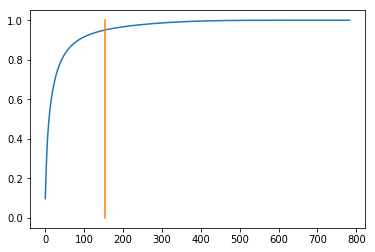

In [37]:
plt.plot(cumsum)
plt.plot([d, d], [0, 1])

* PCA понижает размерность признакового пространства
* Новые компоненты являются линейной комбинацией исходных признаков
* Новые компоненты - ортогональны
* Можно применять в моделях и для визуализации
* Работает не всегда:

<img src="pics/dim_var.png">

# Упражнение

In [38]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

iris = load_iris()
X = iris.data
y = iris.target

X.shape

# Your code here 
# 1. plot the explained variance
# 2. plot the reduced dataset in a 3-dimensional space
# 3. plot the reduced dataset in a 2-dimensional space
# 4. add colours of class labels

(150, 4)

In [39]:
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

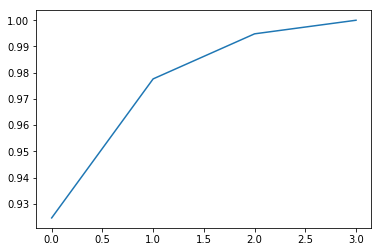

In [40]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [41]:
x_new = PCA(n_components=0.999).fit_transform(X)
x_new.shape

(150, 4)

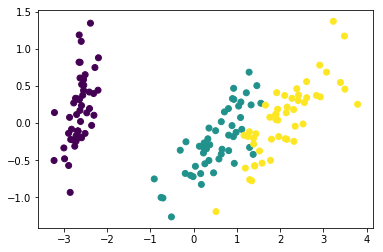

In [42]:
plt.scatter(x_new[:, 0], x_new[:, 1], c=y)

# Применение

### Опросник
Проводится опрос 2000 человек об использовании интернета.  
Опросник состоит из 50 вопросов.  
Получаем датасет размерности 50\*2000  

Если посчитаем главные компоненты, получим числа 50, 29, 17, 10, 2, 1, 1, 0.4, 0.2….
Среди них только первые 4 числа значимы, они показывают те признаки, которые дают больше всего информации.
Можем работать только с 4 признаками, что сильно упрощает работу с данными.

https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/

# Применение для визуализации

In [43]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]

In [44]:
idx = np.random.randint(X.shape[0], size=10000)
X_sample = X[idx,:]
y_sample = y[idx]

X_sample.shape, X.shape, y_sample.shape, y.shape

((10000, 784), (70000, 784), (10000,), (70000,))

In [45]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_sample)

In [46]:
X_reduced.shape

(10000, 2)

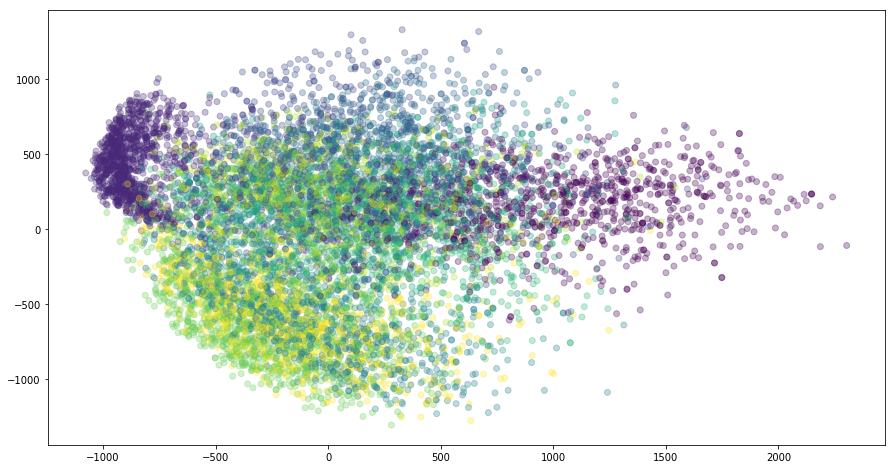

In [47]:
plt.rcParams["figure.figsize"] = (15, 8)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_sample, alpha=0.3)

In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_sample)

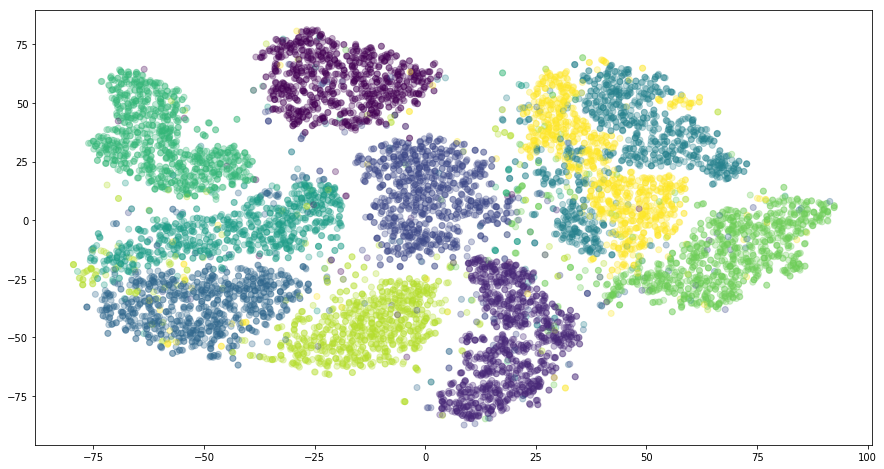

In [49]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_sample, alpha=0.3)

http://lvdmaaten.github.io/tsne

# Для моделей

https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)



In [50]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,...,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12,nan
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,...,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09,nan
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,...,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,nan
3,84348301,M,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,...,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17,nan
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,...,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08,nan


In [51]:
df['diagnosis'] = pd.Categorical(df.diagnosis).codes 
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,...,25.38,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12
1,842517,1,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,...,24.99,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09
2,84300903,1,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,...,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,84348301,1,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,...,14.91,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17
4,84358402,1,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,...,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
diagnosis                  569 non-null int8
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-n

In [53]:
X = df.drop(['id', 'diagnosis'], axis=1).as_matrix()
X.shape

(569, 30)

In [54]:
y = df['diagnosis'].as_matrix()
y.shape

(569,)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [56]:
from sklearn.linear_model import LogisticRegressionCV

In [57]:
lr = LogisticRegressionCV(cv=5)

In [58]:
lr.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [59]:
y_pred = lr.predict(x_test)

In [60]:
roc_auc_score(y_test, y_pred)

0.95225484261501225

In [61]:
pca = PCA()
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [62]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

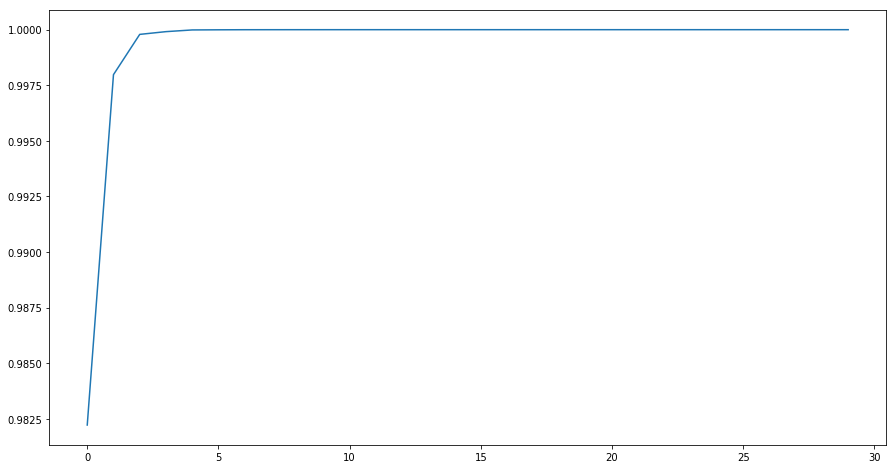

In [63]:
plt.plot(cumsum)

In [64]:
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train)

In [65]:
lr = LogisticRegressionCV(cv=5)
lr.fit(x_train_pca, y_train)
y_pred = lr.predict(pca.transform(x_test))
roc_auc_score(y_test, y_pred)

0.9531628329297821

# Дополнительные материалы
* https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/
* https://www.kaggle.com/nirajvermafcb/principal-component-analysis-explained
* https://plot.ly/ipython-notebooks/principal-component-analysis/
* https://coolstatsblog.com/2015/03/21/principal-component-analysis-explained/
* http://blog.districtdatalabs.com/principal-component-analysis-with-python

In [66]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]

In [67]:
X.shape, y.shape

((70000, 784), (70000,))

In [68]:
idx = np.random.randint(X.shape[0], size=70000)
X_sample = X[idx,:]
y_sample = y[idx]

X_sample.shape, X.shape, y_sample.shape, y.shape

((70000, 784), (70000, 784), (70000,), (70000,))

In [69]:
import time
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
lr = SGDClassifier()

t1 = time.time()
lr.fit(X_sample, y_sample)
t2 = time.time()
print(t2 - t1)

C:\Users\ACLion\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


5.701756238937378


In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=154)
x_new = pca.fit_transform(X_sample)

In [71]:
lr = SGDClassifier()
t1 = time.time()
lr.fit(x_new, y_sample)
t2 = time.time()
print(t2 - t1)

C:\Users\ACLion\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


1.9527816772460938
